# **MNIST Classification w/ MLP**

## **1. Settings**

In [1]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms  # Data augmentation

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# GPU 사용 가능 여부 확인
print(f'CUDA 사용 가능 : {torch.cuda.is_available()}')

# Silicon Mac에서 GPU 사용 가능 여부 확인
print(f'MPS 사용 가능 : {torch.backends.mps.is_available()}')

CUDA 사용 가능 : False
MPS 사용 가능 : True


In [3]:
# # 디바이스 지정
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')

# MNIST는 데이터가 많지 않으므로 CPU로도 충분히 학습 가능 (오히려 GPU에 올렸다 내렸다 하는데 시간이 더 걸림)
device = torch.device('cpu')
print(f'사용 디바이스 : {device}')

사용 디바이스 : cpu


In [4]:
# 재현성을 위한 random seed 설정
# https://pytorch.org/docs/stable/notes/randomness.html

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터 (784 -> 256 -> 128 -> 64 -> 10)
N_HIDDEN = (256, 128, 64)

# 학습에 필요한 하이퍼파라미터
LEARNING_RATE = 0.001
N_EPOCH = 30
PRINT_EVERY = 1
BATCH_SIZE = 256

## **2. Prepare MNIST Dataset**

In [6]:
# MNIST 데이터셋을 불러오기 위한 transform 정의 (텐서로 변환, 정규화)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

# MNIST 데이터셋 다운로드 및 불러오기 (학습데이터)
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transform,
                          download=True)

# MNIST 데이터셋 다운로드 및 불러오기 (테스트데이터)
mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transform,
                         download=True)

# 데이터셋의 크기 확인
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Done.


In [7]:
# 데이터로더 정의하기 (학습데이터: 미니배치, 데이터순서섞음, 멀티프로세싱)
train_iter = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=1)

# 데이터로더 정의하기 (테스트데이터: 미니배치, 멀티프로세싱)
test_iter = torch.utils.data.DataLoader(mnist_test,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=1)

print ("Done.")

Done.


## **3. Create MLP Model**
- 모델 구조

    ```(Input) 784 -> 256 -> 128 -> 64 -> (Output) 10```

- 활성화 함수로는 ReLU를 사용

- 배치 정규화 및 드롭아웃을 사용하지 않음 (설정 가능)

- 마지막 출력값에는 softmax를 사용

   - Softmax를 사용하면 주어진 logit을 확률값으로 변환할 수 있음
   
   $$P(class = i) = \frac{e^{logit_i}}{\sum_{j}e^{logit_j}}$$

   - `CrossEntropyLoss = LogSoftmax + NLLLoss`이므로 마지막 레이어에는 softmax를 사용하지 않아도 됨

In [8]:
# Create MLP Model Class
# 모든 모델은 nn.Module을 상속받아야 함

class MLP(nn.Module):
    ''' Initialize the model '''
    def __init__(self, n_hidden_list, dropout_p=0, batch_norm=False):
        '''
        n_hidden_list: 각 hidden layer의 노드 수를 담은 리스트
        dropout_p: dropout 확률 (0~1, 0이면 dropout을 사용하지 않음)
        batch_norm: batch normalization 사용 여부
        '''
        super(MLP, self).__init__()

        # FC layer를 담을 리스트 (nn.ModuleList 사용)
        self.fc_layers = nn.ModuleList(
            # 입력 레이어 : 28*28 -> hidden_size
            [nn.Linear(28*28, n_hidden_list[0])]
            # 히든 레이어 : hidden_size -> hidden_size
            + [nn.Linear(n_hidden_list[i], n_hidden_list[i+1])
               for i in range(len(n_hidden_list)-1)]
            # 출력 레이어 : hidden_size -> 10
            + [nn.Linear(n_hidden_list[-1], 10)]
        )

        # Batch normalization 사용 여부
        self.batch_norm = batch_norm
        if batch_norm:
            # BN layer를 담을 리스트 (nn.ModuleList 사용)
            self.bn_layers = nn.ModuleList(
                [nn.BatchNorm1d(n_hidden_list[i]) for i in range(len(n_hidden_list))]
            )

        # Dropout 사용 여부
        self.dropout_p = dropout_p
        if dropout_p:
            # Dropout layer를 담을 리스트 (nn.ModuleList 사용)
            self.dropout_layers = nn.ModuleList(
                [nn.Dropout(dropout_p) for _ in range(len(n_hidden_list))]
            )

        # 가중치 초기화 함수 호출
        self.init_weights()

    ''' 순방향 전파 (함수 이름은 forward로 고정)'''
    def forward(self, x):
        # 입력 데이터를 1차원 텐서로 변환 (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, 28*28)

        # FC layer -> BN -> ReLU -> Dropout 반복
        for i, fc_layer in enumerate(self.fc_layers):
            # FC layer
            x = fc_layer(x)

            # 마지막 layer를 제외하고 BN -> ReLU -> Dropout 반복
            if i < len(self.fc_layers) - 1:
                # Batch normalization
                if self.batch_norm:
                    x = self.bn_layers[i](x)

                # ReLU
                x = F.relu(x)

                # Dropout
                if self.dropout_p:
                    x = self.dropout_layers[i](x)

        return x  # (batch_size, 10)

    ''' 모델 가중치 초기화 함수 '''
    def init_weights(self):
        # self.modules()는 모델의 모든 레이어를 반복하는 generator를 반환
        for m in self.modules():
            # nn.Linear 레이어만 가중치 초기화
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

## **4. Train & Test**

In [9]:
# MLP 모델 생성 (N_HIDDEN = (64, 16), 드롭아웃 미사용, 배치정규화 미사용)
# GPU 사용시 모델을 GPU 메모리에 올려야 함
model = MLP(N_HIDDEN, dropout_p=0, batch_norm=False).to(device)

# 손실함수 정의
# nn.CrossEntropyLoss()는 nn.LogSoftmax()와 nn.NLLLoss()를 합친 것
# 마찬가지로, 디바이스에 올려야 함
criterion = nn.CrossEntropyLoss().to(device)

# 옵티마이저 정의
# Adam 옵티마이저 사용
# 모델의 파라미터를 옵티마이저에 올려야 함 (nn.Module을 상속받았으므로, model.parameters()로 접근 가능)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
def acc_fn(output, target):
    '''정확도 계산 함수'''
    with torch.no_grad():
        # output: (batch_size, 10)
        # target: (batch_size)
        pred = output.argmax(dim=1, keepdim=True)  # (batch_size, 1)
        correct = pred.eq(target.view_as(pred)).sum()  # True: 1, False: 0
        acc = correct.float() / target.size(0)  # 정확도 = 맞은 개수 / 전체 개수

        return acc.item()

def acc_model(model, data_iter, device):
    '''모델 정확도 계산 함수'''
    corrects, total = 0, 0
    for batch in data_iter:
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        corrects += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)
    
    return corrects / total

In [11]:
# 학습 시작
model.train()  # train mode로 변경

# N_EPOCH 만큼 반복
for epoch in tqdm(range(N_EPOCH)):
    train_cost, train_acc = 0, 0

    # train_iter에서 미니배치를 하나씩 꺼내옴
    for X, Y in train_iter:
        # 모델이 GPU 메모리에 올라가 있는 경우, 미니배치도 GPU 메모리에 올려야 함
        X = X.to(device)
        Y = Y.to(device)

        # Gradient를 0으로 초기화 (backward()를 하기 전에 꼭 해야 함)
        optimizer.zero_grad()
        # 순방향 전파
        hypothesis = model(X)
        # 손실값 계산
        cost = criterion(hypothesis, Y)
        # 역전파 (Gradient 계산)
        cost.backward()
        # 파라미터 업데이트
        optimizer.step()

        # 현재 미니배치의 손실값을 더해줌
        train_cost += cost.item()
    
    # Print the average cost in every PRINT_EVERY epoch
    if (epoch+1) % PRINT_EVERY == 0:
        avg_cost = train_cost / len(train_iter)
        train_acc = acc_model(model, train_iter, device)
        print(f'[Epoch {epoch+1:2d}/{N_EPOCH:2d}] '
              f'Train Cost: {avg_cost:.9f} | Acc: {train_acc*100:.2f} %')

print('Learning finished')

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch  1/30] Train Cost: 0.382847445 | Acc: 94.72 %
[Epoch  2/30] Train Cost: 0.154758645 | Acc: 96.49 %
[Epoch  3/30] Train Cost: 0.113453553 | Acc: 97.44 %
[Epoch  4/30] Train Cost: 0.092804519 | Acc: 97.50 %
[Epoch  5/30] Train Cost: 0.076096024 | Acc: 98.19 %
[Epoch  6/30] Train Cost: 0.065790065 | Acc: 98.20 %
[Epoch  7/30] Train Cost: 0.059201595 | Acc: 97.93 %
[Epoch  8/30] Train Cost: 0.050549883 | Acc: 98.91 %
[Epoch  9/30] Train Cost: 0.043788885 | Acc: 98.69 %
[Epoch 10/30] Train Cost: 0.038741846 | Acc: 98.88 %
[Epoch 11/30] Train Cost: 0.037330381 | Acc: 99.20 %
[Epoch 12/30] Train Cost: 0.032819995 | Acc: 98.97 %
[Epoch 13/30] Train Cost: 0.034776234 | Acc: 98.95 %
[Epoch 14/30] Train Cost: 0.029723451 | Acc: 99.39 %
[Epoch 15/30] Train Cost: 0.029431600 | Acc: 98.87 %
[Epoch 16/30] Train Cost: 0.026482840 | Acc: 99.41 %
[Epoch 17/30] Train Cost: 0.026299078 | Acc: 99.22 %
[Epoch 18/30] Train Cost: 0.021836406 | Acc: 99.39 %
[Epoch 19/30] Train Cost: 0.026214103 | Acc: 9

In [12]:
# 학습이 끝난 모델을 테스트 데이터에 적용
model.eval()  # evaluation mode로 변경 (dropout, batch normalization에 영향을 줌)
test_acc = .0

# torch.no_grad()를 사용하여 gradient 계산을 하지 않도록 함
# 그렇지 않으면, 메모리를 많이 사용하게 됨
with torch.no_grad():
    for X, Y in test_iter:
        X = X.to(device)
        Y = Y.to(device)

        # 순방향 전파
        hypothesis = model(X)
        # 예측값 계산
        prediction = torch.argmax(hypothesis, dim=-1)
        # 정확도 계산
        test_acc += (prediction == Y).sum()
    
    # 정확도 계산
    test_acc /= len(test_iter.dataset)
    
    # 정확도 출력
    print(f'Test Accuracy : {test_acc.item()*100:.2f} %')

Test Accuracy : 97.66 %


## **5. Visualization**

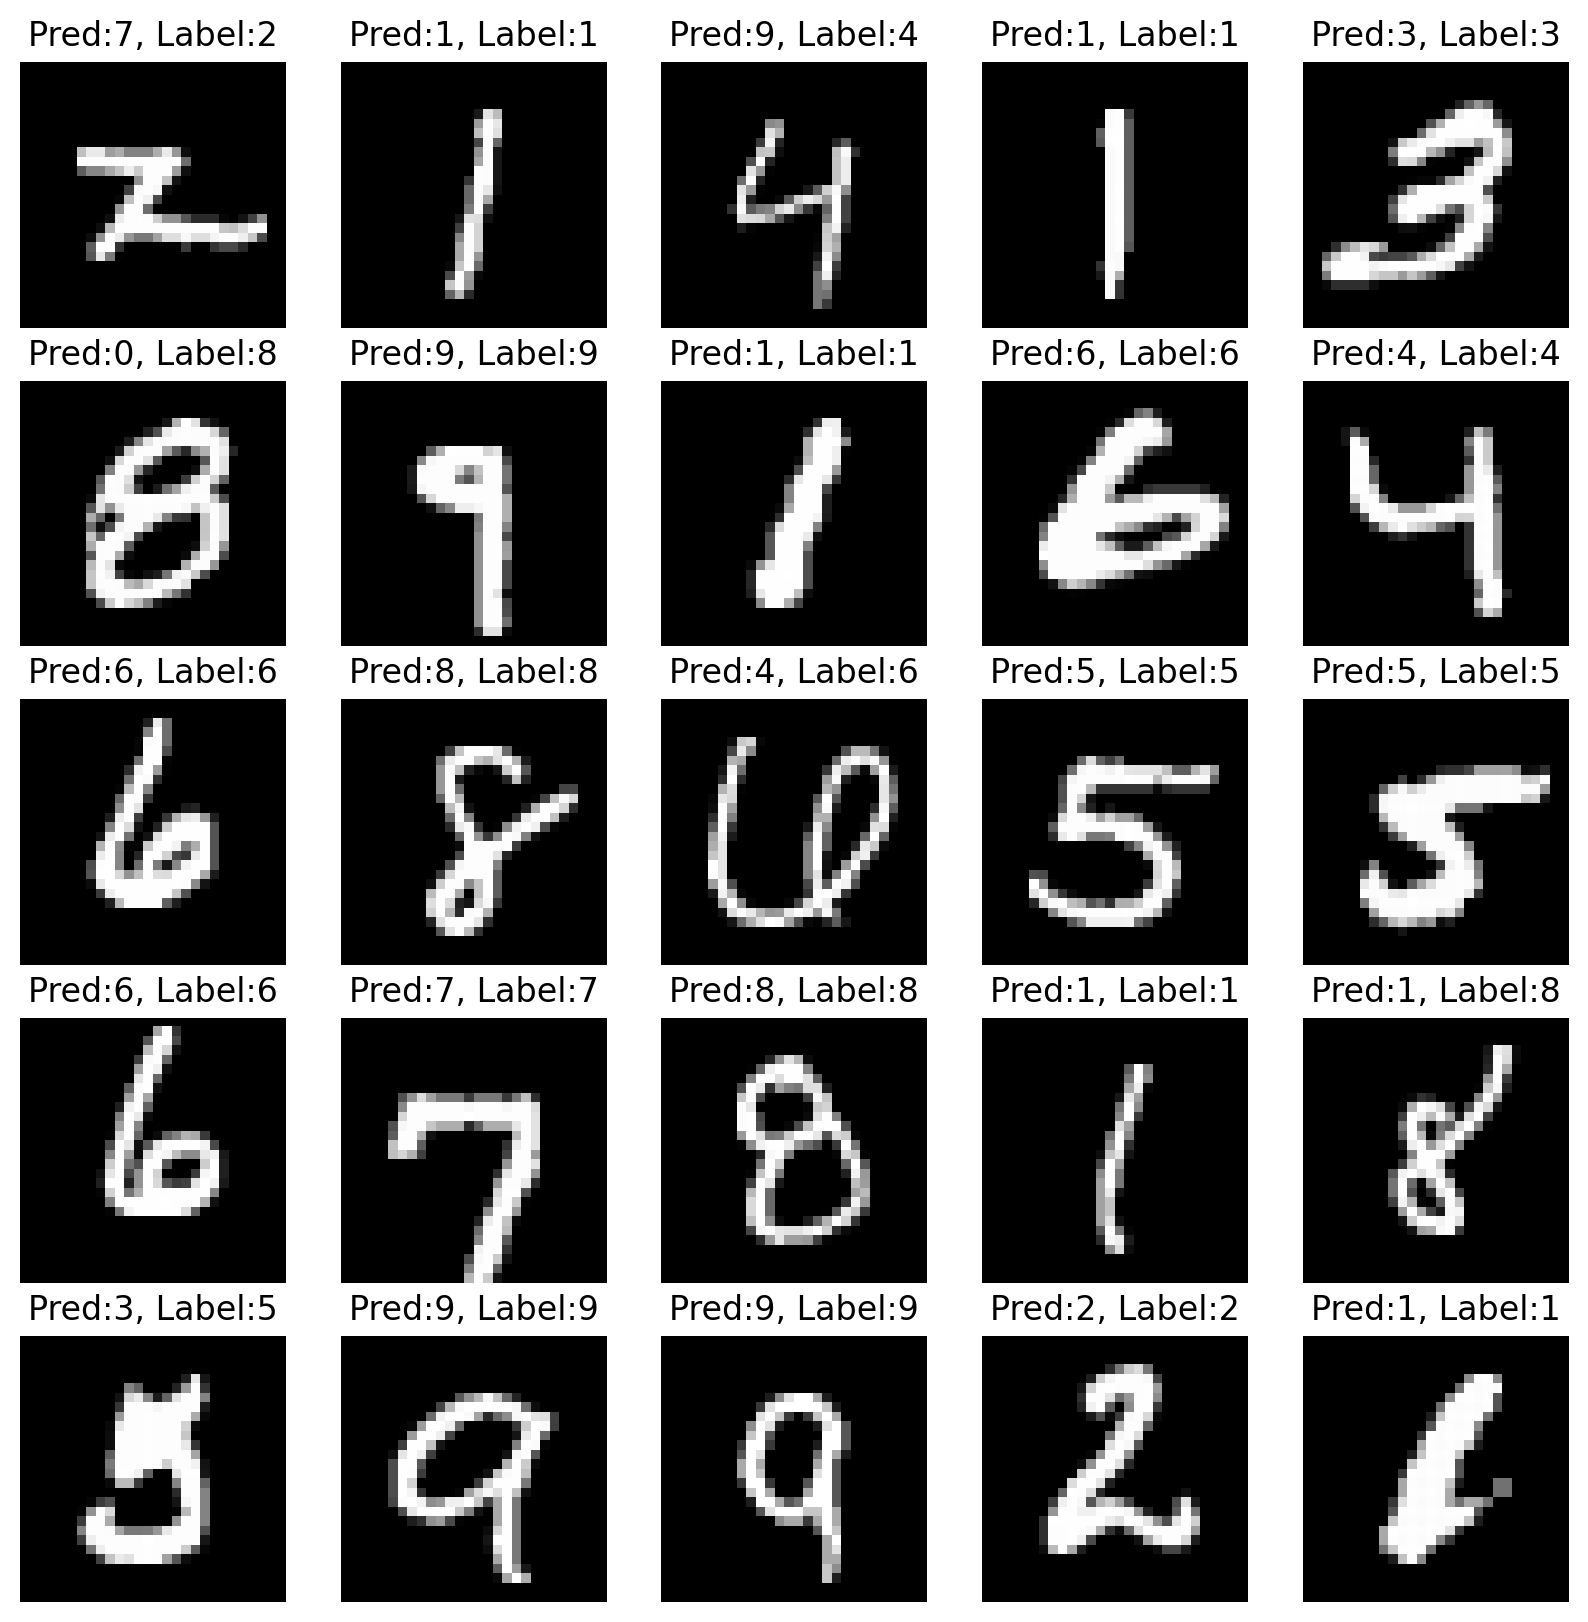

In [13]:
with torch.no_grad():
    n_sample = 25  # number of samples
    
    # n_sample개의 테스트 데이터를 랜덤하게 선택
    sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
    test_x = mnist_test.data[sample_indices]
    test_y = mnist_test.targets[sample_indices]

    # 모델에 입력으로 넣어서 예측값을 계산
    y_pred = model(test_x.float().to(device))
    y_pred = y_pred.argmax(axis=1)

    # 5x5 grid로 테스트 이미지와 예측값 출력
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)  # 5x5 grid에서의 위치 지정
        plt.imshow(test_x[idx], cmap='gray')  # 이미지 출력
        plt.axis('off')  # x축과 y축의 눈금 출력하지 않음
        plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))  # 예측값과 실제값 출력
    plt.show()  # 그림 출력

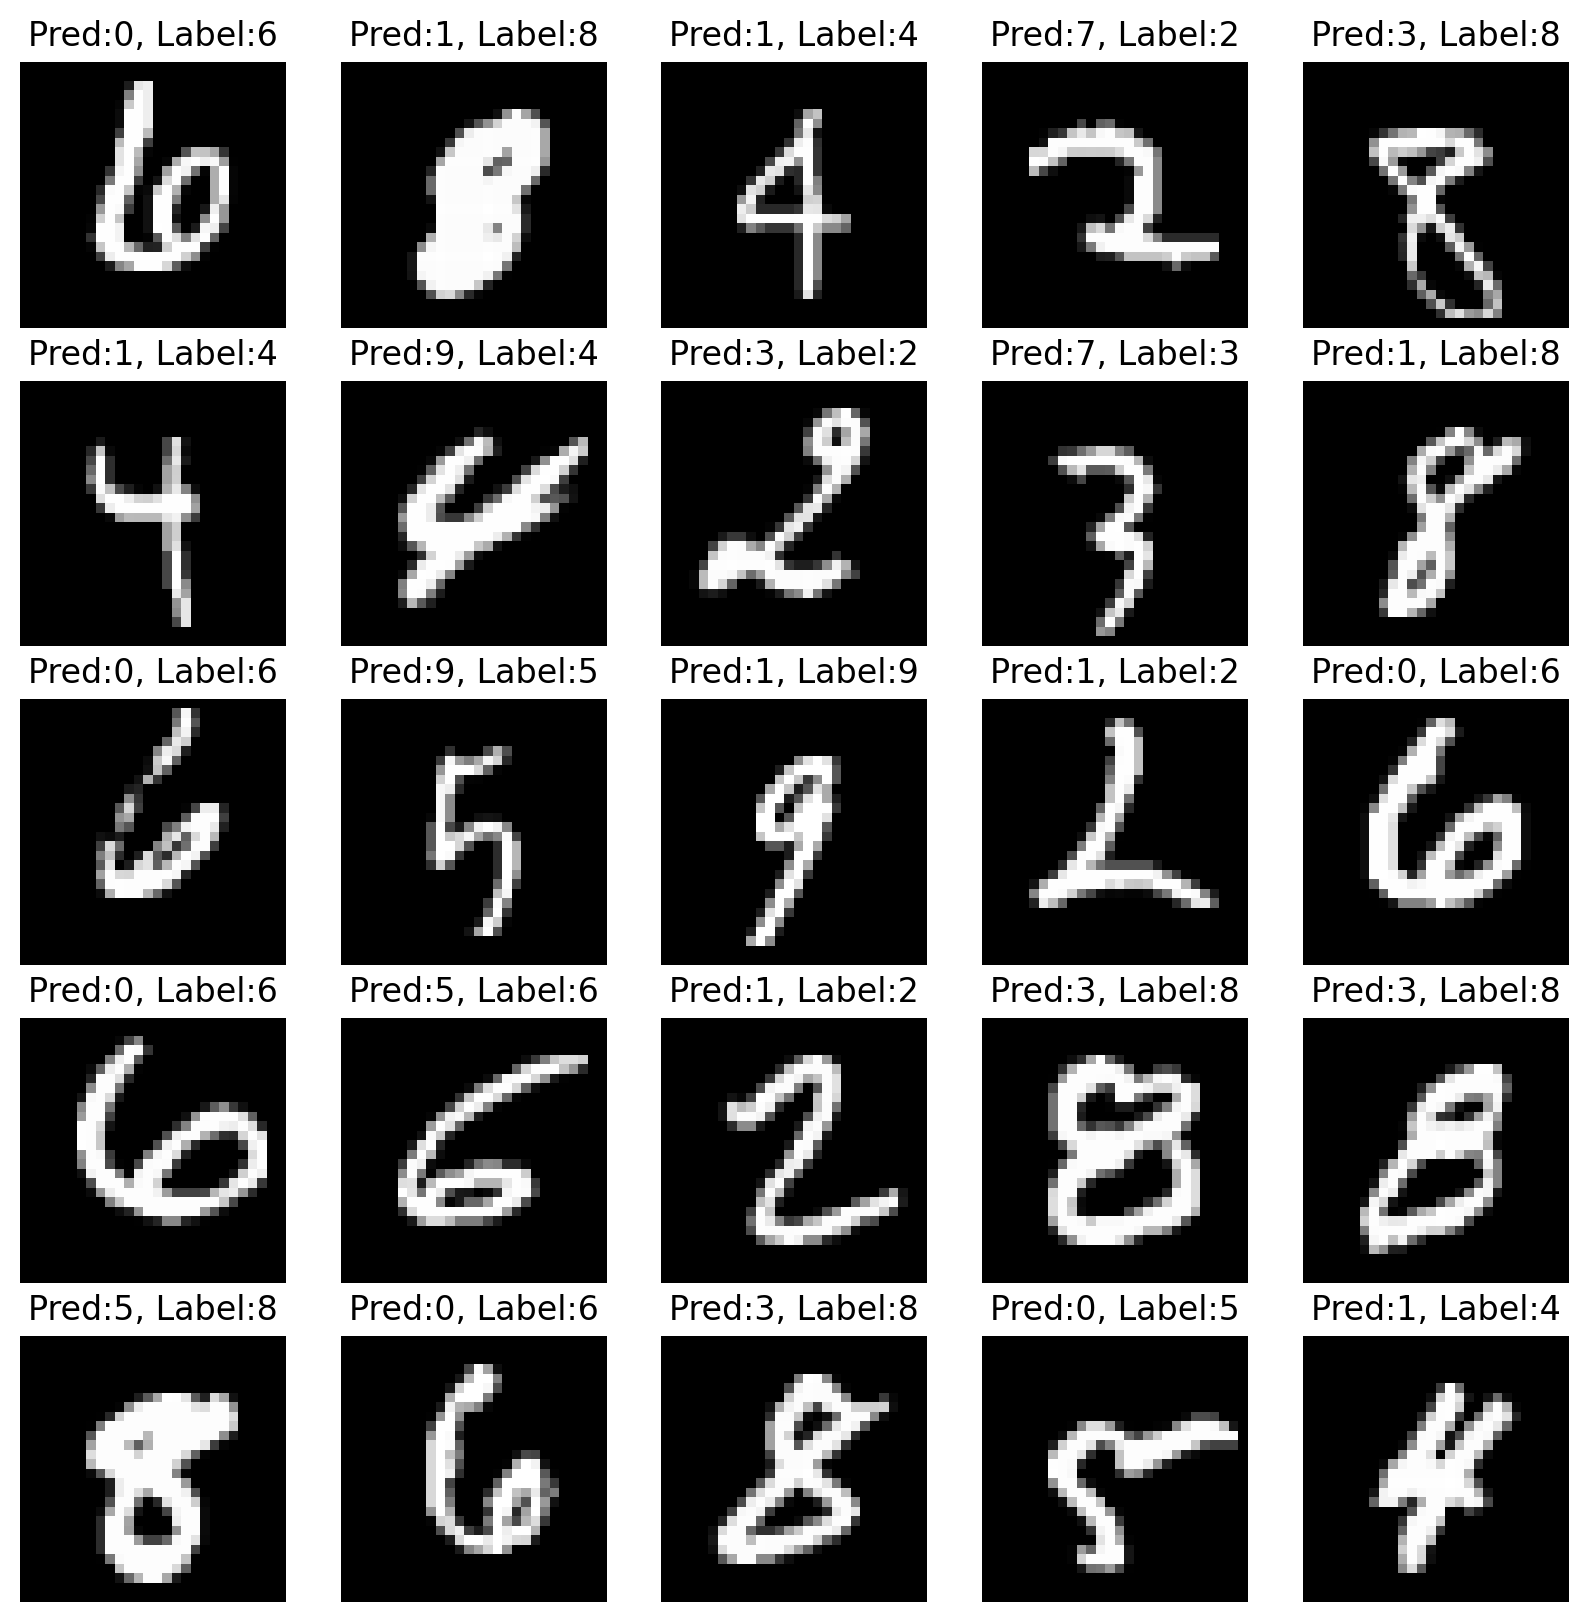

In [14]:
# 정답이 아닌 예측값을 가진 테스트 데이터를 랜덤하게 선택하여 출력

with torch.no_grad():
    test_x = mnist_test.data.float()
    test_y = mnist_test.targets

    # 모델에 입력으로 넣어서 예측값을 계산
    y_pred = model(test_x.to(device))
    y_pred = torch.argmax(y_pred, dim=1)

    # 정답이 아닌 예측값을 가진 테스트 데이터의 인덱스를 추출 (25개)
    n_sample = 25  # number of samples
    correct_prediction = (y_pred == test_y.to(device))
    incorrect_indices = np.where(correct_prediction.cpu() == 0)[0]
    sample_indices = np.random.choice(incorrect_indices, n_sample, replace=False)

    # 5x5 grid로 테스트 이미지와 예측값 출력
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)
        plt.imshow(test_x[sample_indices[idx]], cmap='gray')
        plt.axis('off')
        plt.title("Pred:%d, Label:%d"%(y_pred[sample_indices[idx]],test_y[sample_indices[idx]]))
    plt.show()

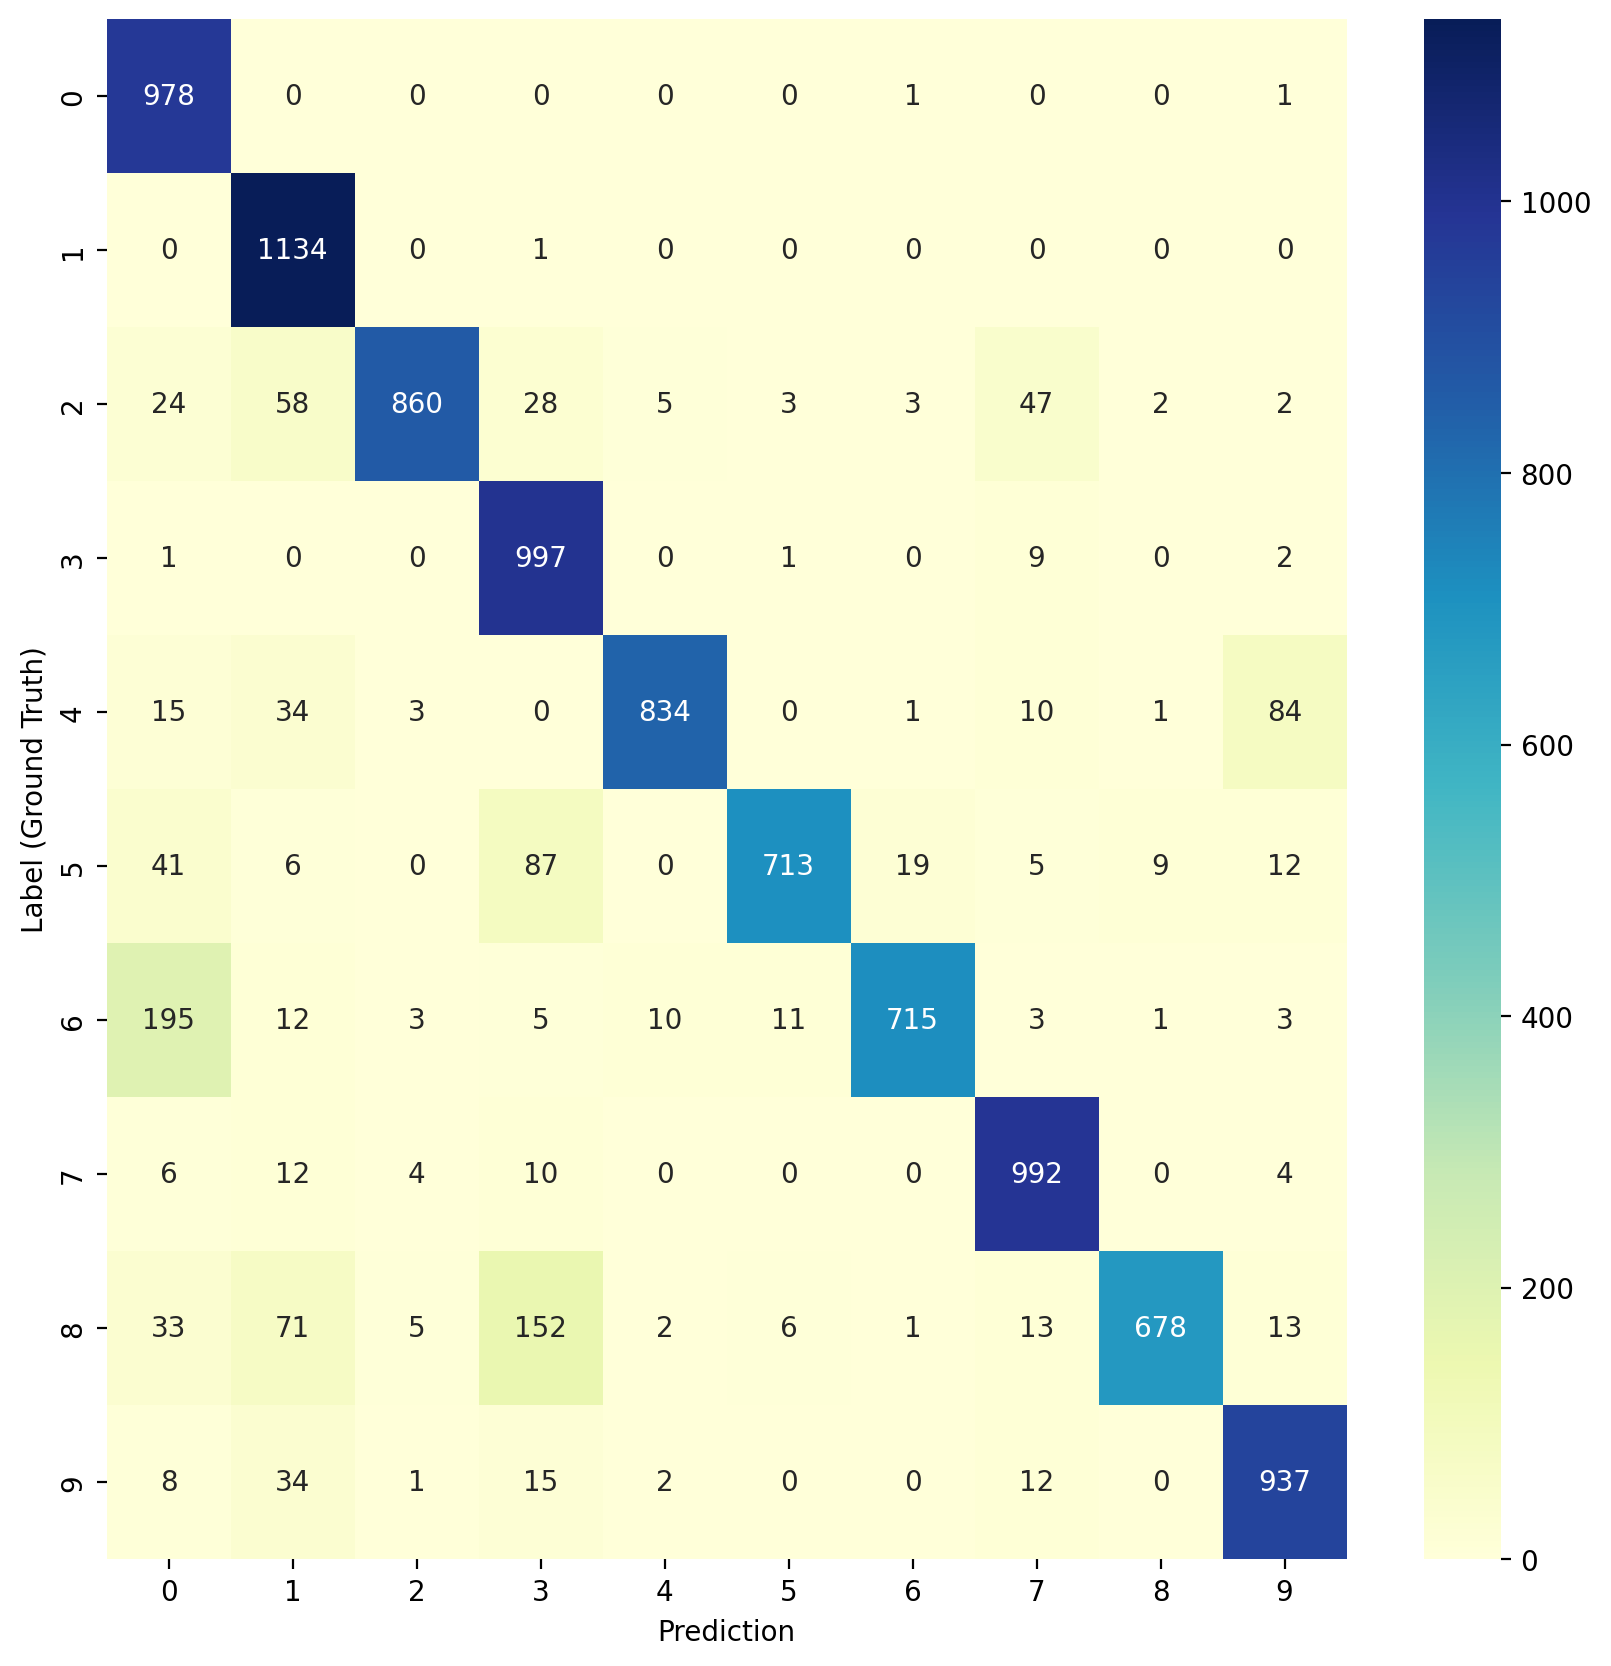

In [15]:
# confusion matrix 계산

with torch.no_grad():
    test_x = mnist_test.data.float()
    test_y = mnist_test.targets

    # 모델에 입력으로 넣어서 예측값을 계산
    y_pred = model(test_x.to(device))
    y_pred = torch.argmax(y_pred, dim=1)

    # confusion matrix 계산
    n_class = 10  # number of classes
    confusion_matrix = torch.zeros(n_class, n_class, dtype=torch.int64)
    for t, p in zip(test_y.view(-1), y_pred.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
    
    # confusion matrix 출력 (pandas dataframe 사용, color map 사용)
    import pandas as pd
    import seaborn as sns
    plt.figure(figsize=(10,10))
    sns.heatmap(pd.DataFrame(confusion_matrix.numpy()),
                annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel('Prediction')
    plt.ylabel('Label (Ground Truth)')
    plt.show()
    